# Federated Learning Template

In [1]:
import numpy
import sklearn.metrics
import tensorflow
import time

# Graphic libraries
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Data

In [2]:
"""Load some data."""
(xraw_train, yraw_train), (xraw_test, yraw_test) = tensorflow.keras.datasets.fashion_mnist.load_data()

xraw_train.shape, yraw_train.shape, xraw_test.shape, yraw_test.shape, xraw_train.dtype, xraw_train.max()

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,), dtype('uint8'), 255)

In [3]:
"""Preprocess the data.

In addition, shuffle the data.
Set the random seed (so we can replicate the experiment).
"""
batch_size = 32

# Training Set
x_train_all = xraw_train.astype('float32').reshape(-1, 28, 28, 1)/255
y_train_all = tensorflow.one_hot(yraw_train, 10).numpy().astype('int32')
train_dataset = tensorflow.data.Dataset.from_tensor_slices((x_train_all, y_train_all))
train_dataset = train_dataset.shuffle(buffer_size=1024, seed=56).batch(batch_size)

# Validation Set
x_valid_all = xraw_test.astype('float32').reshape(-1, 28, 28, 1)/255
y_valid_all = tensorflow.one_hot(yraw_test, 10).numpy().astype('int32')
valid_dataset = tensorflow.data.Dataset.from_tensor_slices((x_valid_all, y_valid_all)).batch(batch_size)

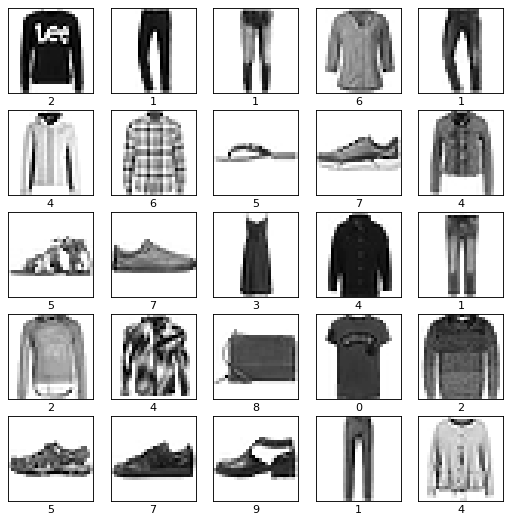

In [4]:
"""Show examples."""
class_names = list(range(10))
offset = 1
one_batch = next(iter(valid_dataset.take(1)))

plt.figure(figsize=(8, 8), dpi=80)
for i in range(25):
    plt.subplot(5, 5, i+1)
    x, y = one_batch
    plt.xticks([]); plt.yticks([]); plt.grid(False)
    plt.imshow(x[i + offset], cmap=plt.cm.binary)
    plt.xlabel(class_names[numpy.argmax(y[i + offset])])

plt.show()

## Training Class

In [5]:
class Learner:

    def __init__(self, train_dataset, valid_dataset):
        """Initialization."""
        self.train_dataset = train_dataset
        self.valid_dataset = valid_dataset
        
        self.model = self._build_model()
        self.optimizer = tensorflow.keras.optimizers.SGD(learning_rate=0.001, momentum=0.95)
        self.loss_function = tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True)
        self.train_acc_metric = tensorflow.keras.metrics.CategoricalAccuracy()
        self.valid_acc_metric = tensorflow.keras.metrics.CategoricalAccuracy()
        
        # Logs and counters
        self.training_batches = 0
        self.logs = []
    
    @staticmethod
    def _build_model():
        """Build model."""
        inputs = tensorflow.keras.Input(shape=(28, 28, 1), name="fashion")
        x = tensorflow.keras.layers.Conv2D(128, 5, activation='relu')(inputs)
        x = tensorflow.keras.layers.MaxPooling2D()(x)
        x = tensorflow.keras.layers.Conv2D(128, 7, activation='relu')(x)
        x = tensorflow.keras.layers.MaxPooling2D()(x)
        x = tensorflow.keras.layers.Flatten()(x)
        x = tensorflow.keras.layers.Dense(512, activation="relu")(x)
        outputs = tensorflow.keras.layers.Dense(10, name="predictions")(x)  # linear activation!
        return tensorflow.keras.Model(inputs=inputs, outputs=outputs, name=f'CustomModel')
    
    def train(self, batches=-1, log=False, verbose=False):
        """Train several batches."""
        start_time = time.time()

        loss_log = []
        for x_batch_train, y_batch_train in self.train_dataset.take(batches):                
            self.training_batches += 1
            loss_value = self._train_step(x_batch_train, y_batch_train)
            loss_log.append(loss_value)
        mean_loss = numpy.mean(loss_log)
            
        train_acc = float(self.train_acc_metric.result())
        self.train_acc_metric.reset_states()     
        
        if verbose:
            print(f'Training acc: {train_acc:.4f}')
            print(f'Time taken to complete training: {time.time() - start_time:.2f} s')
        if log:
            self.logs.append({
                'type': 'training', 'training_batches':  self.training_batches,
                'mean_training_loss': mean_loss, 'training_acccuracy': train_acc})
            
        return mean_loss, train_acc

    @tensorflow.function
    def _train_step(self, x, y):
        """Perform one step of training."""
        with tensorflow.GradientTape() as tape:
            logits = self.model(x, training=True)
            loss_value = self.loss_function(y, logits)
        grads = tape.gradient(loss_value, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.train_acc_metric.update_state(y, logits)
        return loss_value
    
    def validate(self, log=False, verbose=False):
        """Validate model."""
        start_time = time.time()
        
        loss_log = []
        for x_batch_val, y_batch_val in self.valid_dataset:
            loss_value = self._valid_step(x_batch_val, y_batch_val)
            loss_log.append(loss_value)
        mean_loss = numpy.mean(loss_log)
            
        valid_acc = float(self.valid_acc_metric.result())
        self.valid_acc_metric.reset_states()
        
        if verbose:
            print(f'Validation acc: {valid_acc:.4f}')
            print(f'Time taken to complete validation: {time.time() - start_time:.2f} s')
        if log:
            self.logs.append({
                'type': 'validation', 'training_batches':  self.training_batches,
                'mean_validation_loss': mean_loss, 'vaidation_accuracy': valid_acc})
        
        return mean_loss, valid_acc
    
    @tensorflow.function
    def _valid_step(self, x, y):
        logits = self.model(x, training=False)
        self.valid_acc_metric.update_state(y, logits)
        return self.loss_function(y, logits)
    
    def get_confusion_matrix(self, verbose=False):
        """Prepare confussion matrix."""
        val_logits, val_labels = [], []
        for x_batch_val, y_batch_val in self.valid_dataset:
            logits = self.model(x_batch_val, training=False)
            val_logits.append(logits.numpy())
            val_labels.append(y_batch_val)
        val_logits = numpy.vstack(val_logits)
        val_labels = numpy.vstack(val_labels)

        val_logits = numpy.argmax(val_logits, axis=-1)
        val_labels = numpy.argmax(val_labels, axis=-1)

        # y axis shows true labels, x axis shows the predicted labels
        m = sklearn.metrics.confusion_matrix(
            y_true=val_labels, y_pred=val_logits,
            labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
        
        if verbose:
            print('Accuracy:', sklearn.metrics.accuracy_score(val_logits, val_labels))
        
        return m
    
    def plot_weights_values(self, layer, xdim=None, scale=None, verbose=False, zoom=False):
        """Show the values of the weights in one layer."""
        weights = self.model.get_weights()[layer]
        if not scale:
            scale = numpy.abs(weights.flatten()).max()
        if xdim:
            print(f'--> Reshaping {weights.shape}...')
            weights = weights.reshape((xdim, -1))
        if len(weights.shape) != 2:
            print(f'--> Reshaping {weights.shape}...')
            weights = weights.reshape((-1, weights.shape[-1]))
        if zoom:
            a, b, c, d = zoom
            weights = weights[a:b,c:d]
        
        plt.figure(dpi=100, figsize=(5, 5))
        plt.imshow(weights, cmap='bwr', interpolation='none', vmin=-scale, vmax=scale)
        plt.show()

        if verbose:
            print(f'Scale from {-scale} to {scale}')
            nonzero = numpy.abs(weights.flatten()) > 10**(-5)
            print(f'Proportion of non-zero weights: {sum(nonzero)/len(nonzero)}')

## Simple Demonstration

In [6]:
student = Learner(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset
)
student.model.summary()

Model: "CustomModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fashion (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 24, 24, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 128)         802944    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 3, 3, 128)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1152)              

In [7]:
student.train(2000, verbose=True, log=True)

Training acc: 0.7423
Time taken to complete training: 6.68 s


(0.7107649, 0.7422666549682617)

In [8]:
student.validate(verbose=True, log=True)

Validation acc: 0.8199
Time taken to complete validation: 0.22 s


(0.5050348, 0.8198999762535095)

In [9]:
student.get_confusion_matrix(verbose=True)

Accuracy: 0.8199


array([[828,   3,  24,  19,   6,   4, 107,   0,   9,   0],
       [  9, 953,   2,  21,   5,   0,   8,   0,   2,   0],
       [ 12,   1, 650,   3, 167,   0, 159,   0,   8,   0],
       [ 54,  18,   6, 743,  79,   0,  97,   0,   3,   0],
       [  1,   2,  91,  10, 754,   1, 136,   0,   5,   0],
       [  0,   1,   0,   0,   0, 921,   0,  42,   4,  32],
       [195,   1, 109,  18, 109,   1, 546,   0,  21,   0],
       [  0,   0,   0,   0,   0,  37,   0, 908,   0,  55],
       [  3,   3,  13,   6,   6,   1,  23,   5, 939,   1],
       [  0,   0,   0,   0,   0,   8,   0,  34,   1, 957]])

In [10]:
student.train(100, log=True, verbose=True)

Training acc: 0.8341
Time taken to complete training: 0.16 s


(0.4674499, 0.8340625166893005)

In [11]:
student.validate(log=True, verbose=True)

Validation acc: 0.8046
Time taken to complete validation: 0.16 s


(0.5170105, 0.8046000003814697)

In [12]:
student.logs

[{'type': 'training',
  'training_batches': 1875,
  'mean_training_loss': 0.7107649,
  'training_acccuracy': 0.7422666549682617},
 {'type': 'validation',
  'training_batches': 1875,
  'mean_validation_loss': 0.5050348,
  'vaidation_accuracy': 0.8198999762535095},
 {'type': 'training',
  'training_batches': 1975,
  'mean_training_loss': 0.4674499,
  'training_acccuracy': 0.8340625166893005},
 {'type': 'validation',
  'training_batches': 1975,
  'mean_validation_loss': 0.5170105,
  'vaidation_accuracy': 0.8046000003814697}]

--> Reshaping (5, 5, 1, 128)...


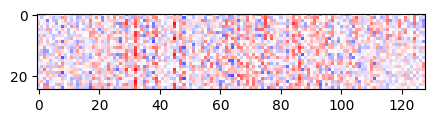

Scale from -0.1677764505147934 to 0.1677764505147934
Proportion of non-zero weights: 1.0


In [13]:
student.plot_weights_values(layer=0, verbose=True)

--> Reshaping (7, 7, 128, 128)...


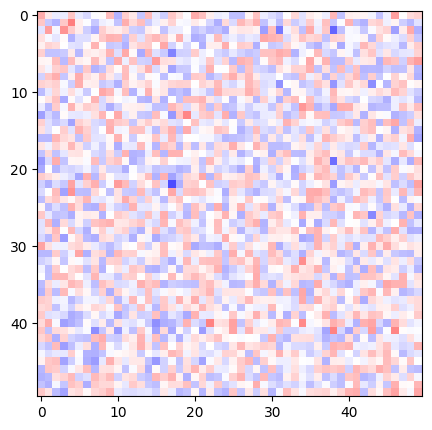

In [14]:
student.plot_weights_values(layer=2, xdim=28*32, zoom=(100, 150, 100, 150))

## Federated Learning

In [15]:
labels = numpy.argmax(y_train_all, axis=-1)
a = (labels == 0) | (labels == 1) | (labels == 2)
b = (labels == 3) | (labels == 4)
c = (labels == 5) | (labels == 6)
d = (labels == 7) | (labels == 8) | (labels == 9)

In [16]:
partial_train_dataset = {}
for i, s in enumerate([a, b, c, d]):
    partial_train_dataset[i] = tensorflow.data.Dataset.from_tensor_slices(
        (x_train_all[s], y_train_all[s])).shuffle(buffer_size=1024, seed=56).batch(batch_size)

partial_valid_dataset = {}
for i in range(4):
    n, k = 1_000*i, 1_000*(i+1)
    partial_valid_dataset[i] = tensorflow.data.Dataset.from_tensor_slices(
        (x_valid_all[n:k], y_valid_all[n:k])).batch(batch_size)

In [17]:
client = {}
for i in range(4):
    client[i] = Learner(
        train_dataset=partial_train_dataset[i],
        valid_dataset=partial_valid_dataset[i]
    )

In [18]:
community = Learner(
    train_dataset=train_dataset,
    valid_dataset=valid_dataset
)

In [19]:
for r in range(20):
    print(f'\n*** Round {r}')
    
    print(f'--- Distributing Weights Among Clients')
    for c in range(4):
        client[c].model.set_weights(community.model.get_weights())
    
    for c in range(4):
        print(f'--- Training Client {c}')
        client[c].train(verbose=True, log=True)
        client[c].validate(verbose=True, log=True)

    print(f'--- Collecting Weights')
    weights = [[] for _ in range(len(community.model.get_weights()))]
    for c in range(4):
        for i, w in enumerate(client[c].model.get_weights()):
            weights[i].append(w)

    print(f'--- Averaging Weights')
    averaged = [
        0.6*c + 0.4*numpy.array(w).mean(axis=0)
        for c, w in zip(community.model.get_weights(), weights)]
    
    print(f'--- Sending Weights to the Community Model ')
    community.model.set_weights(averaged)
    community.validate(verbose=True, log=True)


*** Round 0
--- Distributing Weights Among Clients
--- Training Client 0
Training acc: 0.8981
Time taken to complete training: 1.91 s
Validation acc: 0.3080
Time taken to complete validation: 0.09 s
--- Training Client 1
Training acc: 0.8665
Time taken to complete training: 1.30 s
Validation acc: 0.1860
Time taken to complete validation: 0.08 s
--- Training Client 2
Training acc: 0.9438
Time taken to complete training: 1.23 s
Validation acc: 0.1890
Time taken to complete validation: 0.08 s
--- Training Client 3
Training acc: 0.9018
Time taken to complete training: 2.06 s
Validation acc: 0.3160
Time taken to complete validation: 0.08 s
--- Collecting Weights
--- Averaging Weights
--- Sending Weights to the Community Model 
Validation acc: 0.2551
Time taken to complete validation: 0.30 s

*** Round 1
--- Distributing Weights Among Clients
--- Training Client 0
Training acc: 0.9189
Time taken to complete training: 1.41 s
Validation acc: 0.3090
Time taken to complete validation: 0.02 s
--

Training acc: 0.9386
Time taken to complete training: 1.06 s
Validation acc: 0.1900
Time taken to complete validation: 0.05 s
--- Training Client 2
Training acc: 0.9952
Time taken to complete training: 0.45 s
Validation acc: 0.1910
Time taken to complete validation: 0.02 s
--- Training Client 3
Training acc: 0.9534
Time taken to complete training: 1.04 s
Validation acc: 0.3200
Time taken to complete validation: 0.02 s
--- Collecting Weights
--- Averaging Weights
--- Sending Weights to the Community Model 
Validation acc: 0.6064
Time taken to complete validation: 0.20 s

*** Round 11
--- Distributing Weights Among Clients
--- Training Client 0
Training acc: 0.9591
Time taken to complete training: 1.20 s
Validation acc: 0.3120
Time taken to complete validation: 0.02 s
--- Training Client 1
Training acc: 0.9361
Time taken to complete training: 1.00 s
Validation acc: 0.1910
Time taken to complete validation: 0.03 s
--- Training Client 2
Training acc: 0.9957
Time taken to complete training:

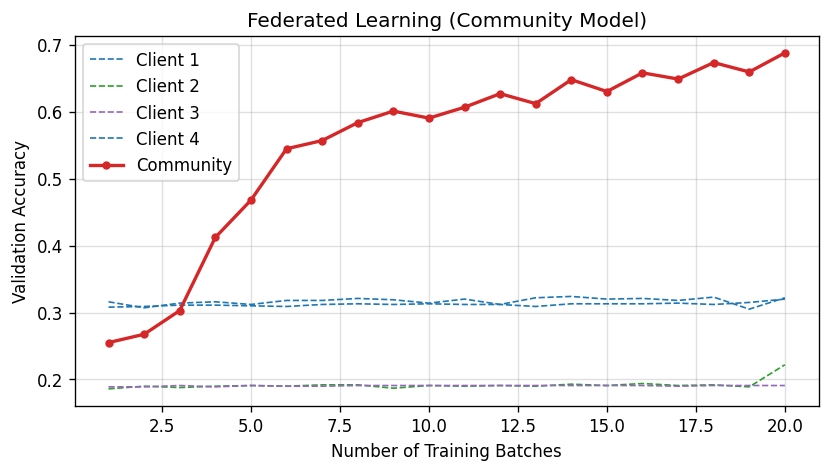

In [20]:
plt.figure(dpi=120, figsize=(8, 4))

# Client
y1 = [log['vaidation_accuracy'] for log in client[0].logs if log['type'] == 'validation']
y2 = [log['vaidation_accuracy'] for log in client[1].logs if log['type'] == 'validation']
y3 = [log['vaidation_accuracy'] for log in client[2].logs if log['type'] == 'validation']
y4 = [log['vaidation_accuracy'] for log in client[3].logs if log['type'] == 'validation']
x = numpy.array(range(len(y1))) + 1
plt.plot(x, y1, '--', color='tab:blue', label='Client 1', lw=1)
plt.plot(x, y2, '--', color='tab:green', label='Client 2', lw=1)
plt.plot(x, y3, '--', color='tab:purple', label='Client 3', lw=1)
plt.plot(x, y4, '--', color='tab:blue', label='Client 4', lw=1)

# Community
x = (numpy.array(range(len(community.logs))) + 1)
y = [log['vaidation_accuracy'] for log in community.logs]
plt.plot(x, y, 'o-', color='tab:red', label='Community', lw=2, ms=4)

plt.title('Federated Learning (Community Model)')
plt.ylabel('Validation Accuracy')
plt.xlabel('Number of Training Batches')
plt.legend()
plt.grid(alpha=0.4)
plt.show()